In [1]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
from urllib.parse import quote

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Załadowanie bazy danych

In [2]:
username = 'team25'
password = quote('te@mzs')
database = 'team25'
host = 'giniewicz.it'
port = '3306'

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

metadata = MetaData()
games_for_sale = Table('games_for_sale', metadata, autoload_with = engine)
games_to_rent = Table('games_to_rent', metadata, autoload_with = engine)
customers = Table('customers', metadata, autoload_with = engine)
staff = Table('staff', metadata, autoload_with = engine)
sale = Table('sale', metadata, autoload_with = engine)
rental = Table('rental', metadata, autoload_with = engine)
competition = Table('competition', metadata, autoload_with = engine)
competition_results = Table('competition_results', metadata, autoload_with = engine)

connection = engine.connect()

In [3]:
"""Funkcja łącząca dwie tabele po podanych kluczach"""
def join_tables(table1, table2, key1, key2):
#     key1, key2 = string(key1), string(key2)
    Session = sessionmaker(bind = engine)
    session = Session()
    query = session.query(table1, table2).filter(getattr(table1.c, key1) == getattr(table2.c, key2)).all()
    column_names = query[0].keys()
    df = pd.DataFrame(query, columns = column_names)
    return df

In [78]:
def join_3tables(table1, table2, table3, key1, key2, key3, key4):
    Session = sessionmaker(bind = engine)
    session = Session()
    query = session.query(table1, table2, table3).filter(getattr(table1.c, 
            key1) == getattr(table2.c, key2)).filter(getattr(table1.c, key3) == getattr(table3.c, key4)).all()
    column_names = query[0].keys()
    df = pd.DataFrame(query, columns = column_names)
    return df

## Problem 1 - ranking na pracownika miesiąca

Pracownika miesiąca można rozumieć jako:
* tego co sprzedał/wypożyczył największą ilość gier
* tego co osiągnął największy przychód z gier

In [4]:
"""Funkcja tworzy wykres słupkowy rankingu dla przykładowego miesiąca"""
def month_ranking_example(df, xlab, year = 2023, month = 5):
    month_names = {1 : 'Styczeń',
                  2 : 'Luty',
                  3 : 'Marzec',
                  4 : 'Kwiecień',
                  5 : 'Maj',
                  6 : 'Czerwiec',
                  7 : 'Lipiec',
                  8 : 'Sierpień',
                  9 : 'Wrzesień', 
                  10 : 'Październik',
                  11 : 'Listopad', 
                  12 : 'Grudzień'}
    df = df.xs(year, level = 'year').xs(month, level = 'month')[:5].sort_values(ascending = False)
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize = (15, 7))
    ax = sns.barplot(x = df.values, y = df.index, orient='h', palette = ['goldenrod', 'silver', 'sienna', 'powderblue' , 'powderblue'])
    ax.bar_label(ax.containers[0], fmt= '%.0f', label_type='edge')
    ax.set_xlabel(xlab)
    ax.set_ylabel('')
    ax.set_title('Ranking miesiąca: ' + month_names[month] + ' ' + str(year))
    plt.show()

In [5]:
df1_sale = join_tables(sale, staff, 'staff_id', 'staff_id')
df1_sale = df1_sale.loc[:, ~df1_sale.columns.duplicated()]
df1_sale = df1_sale[['staff_id', 'amount', 'date', 'first_name', 'last_name']]
# df1_sale.head()

In [6]:
df1_sale['full_name'] = df1_sale['first_name'] + ' ' + df1_sale['last_name']
df1_sale = df1_sale.drop(['first_name', 'last_name'], axis = 1)
# df1_sale.head()

In [7]:
df1_sale['day'] = pd.to_datetime(df1_sale['date']).dt.day
df1_sale['month'] = pd.to_datetime(df1_sale['date']).dt.month
df1_sale['year'] = pd.to_datetime(df1_sale['date']).dt.year
df1_sale.head()

,staff_id,amount,date,full_name,day,month,year
0,11,67.40,2021-06-02,Mateusz Kowalski,2,6,2021
1,5,424.80,2021-06-02,Zuzanna Brzozowska,2,6,2021
2,3,938.40,2021-06-02,Jan Błotny,2,6,2021
3,13,112.78,2021-06-02,Jakub Kozioł,2,6,2021
4,8,199.80,2021-06-04,Kacper Reszke,4,6,2021


### Ranking na największy przychód

In [8]:
best_staff = df1_sale.groupby(['year', 'month', 'full_name'])['amount'].sum()
best_staff

year  month  full_name             
2021  6      Aleksander Magdaleński     4167.70
             Aleksander Szymaszczyk     2762.26
             Antonina Hemmerling        3992.07
             Bartosz Hetman             2718.87
             Filip Pawlaczyk            1823.59
                                         ...   
2023  6      Nikodem Pryczek           23746.09
             Oliwia Gollasch           19882.18
             Tymoteusz Wieczorek       20741.43
             Weronika Bloch            22540.10
             Zuzanna Brzozowska        24640.12
Name: amount, Length: 425, dtype: float64

In [9]:
best_staff.xs(2021, level = 'year').xs(10, level = 'month').sort_values(ascending = False)

full_name
Nikodem Pilarz            40842.30
Oliwia Gollasch           38333.20
Bartosz Hetman            37691.73
Nikodem Pryczek           37418.49
Miłosz Wojnicki           34242.45
Kinga Adamowicz           33804.82
Jan Błotny                33764.39
Aleksander Szymaszczyk    29321.15
Zuzanna Brzozowska        28908.76
Aleksander Magdaleński    28533.50
Weronika Bloch            27725.76
Antonina Hemmerling       27703.42
Kacper Reszke             26031.68
Jakub Kozioł              23695.34
Mateusz Kowalski          22598.88
Tymoteusz Wieczorek       20363.93
Filip Pawlaczyk           18435.80
Name: amount, dtype: float64

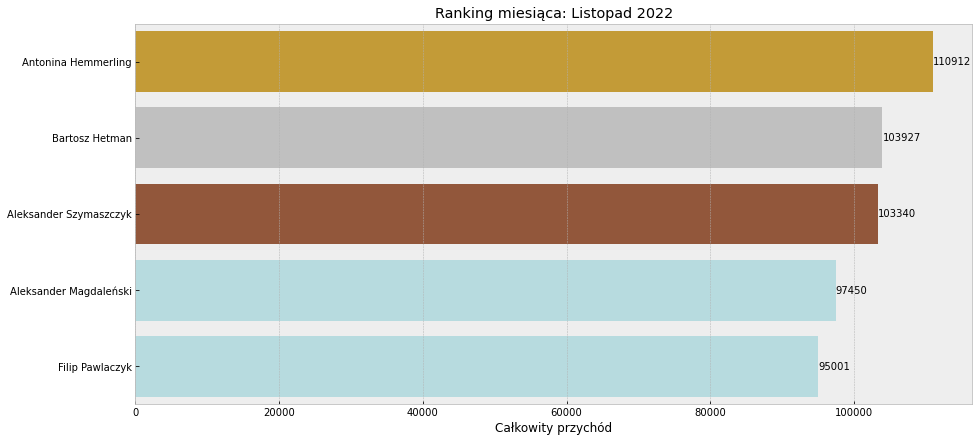

In [10]:
month_ranking_example(best_staff, 'Całkowity przychód', 2022, 11)

### Ranking na największą ilość sprzedanych gier

In [11]:
best_count = df1_sale.groupby(['year', 'month', 'full_name'])['full_name'].count()
best_count

year  month  full_name             
2021  6      Aleksander Magdaleński    10
             Aleksander Szymaszczyk    12
             Antonina Hemmerling       14
             Bartosz Hetman            15
             Filip Pawlaczyk           11
                                       ..
2023  6      Nikodem Pryczek           96
             Oliwia Gollasch           83
             Tymoteusz Wieczorek       83
             Weronika Bloch            91
             Zuzanna Brzozowska        78
Name: full_name, Length: 425, dtype: int64

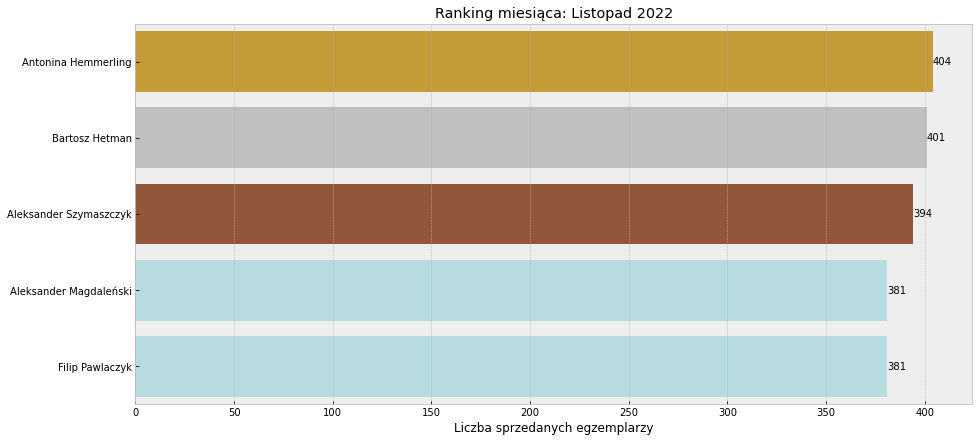

In [12]:
month_ranking_example(best_count, 'Liczba sprzedanych egzemplarzy', 2022, 11)

## Problem 2 - top 10 zawodników turniejowych

## Problem 3 - gry najbardziej dochodowe

### Sprzedaż

In [13]:
df3_sale = join_tables(games_for_sale, sale, 'game_id', 'game_id')
df3_sale = df3_sale.loc[:, ~df3_sale.columns.duplicated()]
df3_sale = df3_sale[['name', 'amount', 'date']]
df3_sale.head()

,name,amount,date
0,Samara,67.40,2021-06-02
1,Fleet Commander: Nimitz,424.80,2021-06-02
2,Fire in the East,938.40,2021-06-02
3,WildLife,112.78,2021-06-02
4,Barcelona: The Rose of Fire,199.80,2021-06-04


In [57]:
best5 = df3_sale.groupby('name').sum().sort_values(by = 'amount', ascending = False)[:5]
best5

,amount
name,
Case Blue,124052.00
Tales of the Arabian Nights,106507.84
Warhammer Quest: Shadows Over Hammerhal,93229.32
Titan,92631.00
Space Hulk (fourth edition),80780.05


In [59]:
best5_timelapse = df3_sale[df3_sale.name.isin(best5.index) == True]
best5_timelapse = best5_timelapse.groupby(['name', 'date']).sum()
best5_timelapse

amount
name                                    date               
Case Blue                               2021-09-23  3448.00
                                        2021-09-28  3442.00
                                        2021-10-08  3441.00
                                        2021-10-26  6891.00
                                        2021-12-28  3442.00
...                                                     ...
Warhammer Quest: Shadows Over Hammerhal 2023-02-22  3326.69
                                        2023-04-03  3329.69
                                        2023-04-11  3328.69
                                        2023-04-18  3327.69
                                        2023-05-04  3325.69

[177 rows x 1 columns]

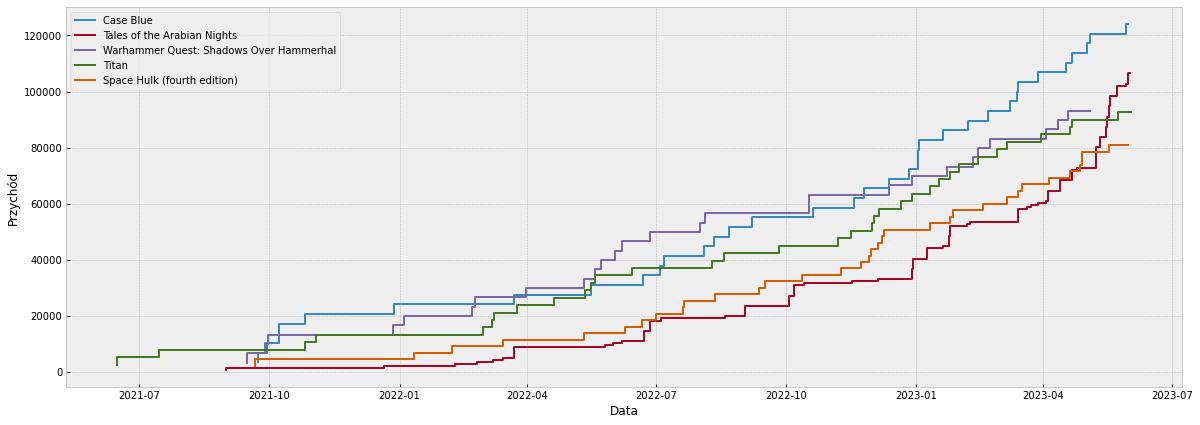

In [61]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (20, 7))
for game in best5.index:
    subgame = best5_timelapse.xs(game, level = 'name').cumsum()
    ax.step(subgame.index, subgame.amount, label = game)
ax.set_xlabel('Data')
ax.set_ylabel('Przychód')
ax.legend()
plt.show()

### Wynajem

In [95]:
df3_rent = join_3tables(games_to_rent, games_for_sale, rental, 'game_id', 'game_id', 'item_id', 'item_id')
df3_rent = df3_rent.loc[:, ~df3_rent.columns.duplicated()]
df3_rent = df3_rent[['name', 'rent_price', 'rental_date', 'return_date']]
df3_rent.head()

,name,rent_price,rental_date,return_date
0,Citadels,2,2021-06-08,2021-06-09
1,Rivet Wars: Eastern Front,5,2021-06-09,2021-06-13
2,Merkator,5,2021-06-11,2021-06-19
3,Band of Brothers: Screaming Eagles,5,2021-06-11,2021-06-12
4,Merchants & Marauders,5,2021-06-14,2021-06-17


In [96]:
df3_rent['days'] = (df3_rent['return_date'] - df3_rent['rental_date']).dt.days
df3_rent['income'] = df3_rent['rent_price']*df3_rent['days']
df3_rent = df3_rent.drop(['rent_price', 'rental_date', 'days'], axis = 1)
df3_rent.head()

,name,return_date,income
0,Citadels,2021-06-09,2
1,Rivet Wars: Eastern Front,2021-06-13,20
2,Merkator,2021-06-19,40
3,Band of Brothers: Screaming Eagles,2021-06-12,5
4,Merchants & Marauders,2021-06-17,15


In [97]:
best5_rent = df3_rent.groupby('name').sum().sort_values(by = 'income', ascending = False)[:5]
best5_rent

,income
name,
Mombasa,3850
Space Hulk (third edition),2700
War of the Ring (Second Edition),2450
Ninjato,2400
Orléans,2375


In [100]:
best5_rent_timelapse = df3_rent[df3_rent.name.isin(best5_rent.index) == True]
best5_rent_timelapse = best5_rent_timelapse.groupby(['name', 'return_date']).sum()
best5_rent_timelapse

income
name                             return_date        
Mombasa                          2021-08-07       10
                                 2021-08-09       30
                                 2021-08-30       30
                                 2021-09-25       30
                                 2021-09-30       30
...                                              ...
War of the Ring (Second Edition) 2023-05-25       30
                                 2023-05-29       90
                                 2023-06-01       30
                                 2023-06-04       20
                                 2023-06-05       30

[498 rows x 1 columns]

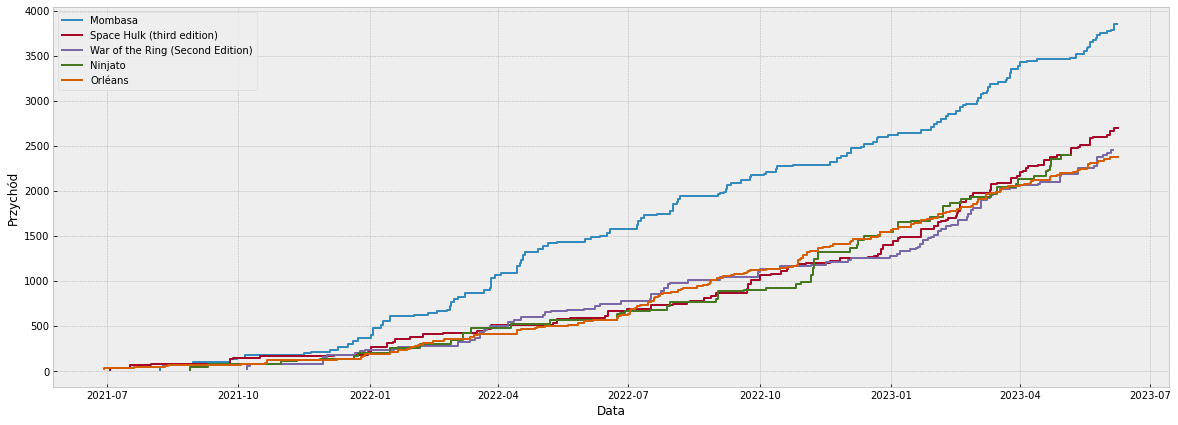

In [101]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (20, 7))
for game in best5_rent.index:
    subgame = best5_rent_timelapse.xs(game, level = 'name').cumsum()
    ax.step(subgame.index, subgame.income, label = game)
ax.set_xlabel('Data')
ax.set_ylabel('Przychód')
ax.legend()
plt.show()

## Problem 4 - najpopularniejsze kategorie

In [66]:
def best_categories(df): # podać dataframe z kolumną category
    categories = df.category.values
    splitted = []
    for category in categories:
        category_split = category.split(', ')
        for indice in category_split:
            splitted.append(indice)
    splitted = np.array(splitted)
    splitted_series = pd.DataFrame(splitted)
    splitted_series.columns = ['Category']
    
    popularity = splitted_series.value_counts().reset_index()
    popularity.columns = ['Category', 'Count']
    first10 = popularity[:10]
    
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    ax.bar(first10['Category'], first10['Count'])
    ax.set_xticklabels(first10['Category'], rotation = 90)
    ax.set_ylabel('Number of games')
    plt.show()

In [78]:
df4 = join_tables(games_for_sale, sale, 'game_id', 'game_id')
df4 = df4.loc[:, ~df4.columns.duplicated()]
df4.head()

,game_id,name,description,min_players,max_players,avg_time,avg_rating,age,availability,category,price,rent_price,sale_id,customer_id,staff_id,amount,date
0,177490,Samara,"Manage time, talent, and tools to efficiently ...",2,5,50,6.37790,10,759,"City Building, Medieval",44.40,2,1,NaN,11,67.40,2021-06-02
1,105023,Fleet Commander: Nimitz,None,1,1,180,6.97894,0,627,"Nautical, Wargame, World War II",421.80,5,2,NaN,5,424.80,2021-06-02
2,8993,Fire in the East,None,2,4,3000,7.47978,12,669,"Wargame, World War II",932.40,10,3,NaN,3,938.40,2021-06-02
3,3236,WildLife,Fight for survival as one of six animal (or hu...,2,6,120,6.68021,10,1629,"Animals, Prehistoric",110.78,5,4,NaN,13,112.78,2021-06-02
4,205078,Barcelona: The Rose of Fire,None,2,4,90,6.55020,10,325,City Building,199.80,5,5,NaN,8,199.80,2021-06-04


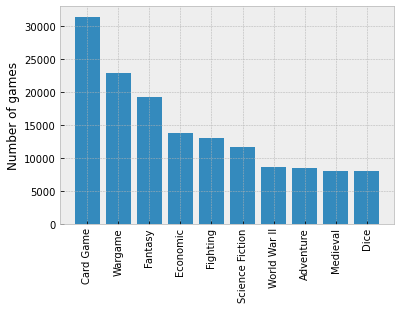

In [67]:
ctgr = best_categories(df4)
ctgr

## Problem 5 - analiza sprzedaży + predykcja